# Regression problems
This tutorial is a base tutorial to teach regression methods with tensorflow. It can be found on https://www.tensorflow.org/tutorials/keras/regression. The goal of the tutorial is to do a regression on fuel consumption from the Auto MPG dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Additional libraries I will use
from random import seed
from random import randint
seed(1)

# Make Numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)


After having loadad all what needed, we proceed to downloading the Auto MPG dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). We additionally drop NAs to clean the dataset and make the tutorial easier. Additionally, we one-hot encode the values in the column 'Origins' with pd.get_dummies (basically transforming the column in 3 columns coded as 0 or 1):


In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()

dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Time to split the dataset in training and test! Note: the argument 'frac' in pd.sample() assigns a percentage of the content to be sampled (e.g., 80%). The argument 'random_state' is just a seed.

In [8]:
training_amount = 0.8
train_dataset = dataset.sample(frac=training_amount, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Data inspection
We use the package Seaborn to inspect the data.

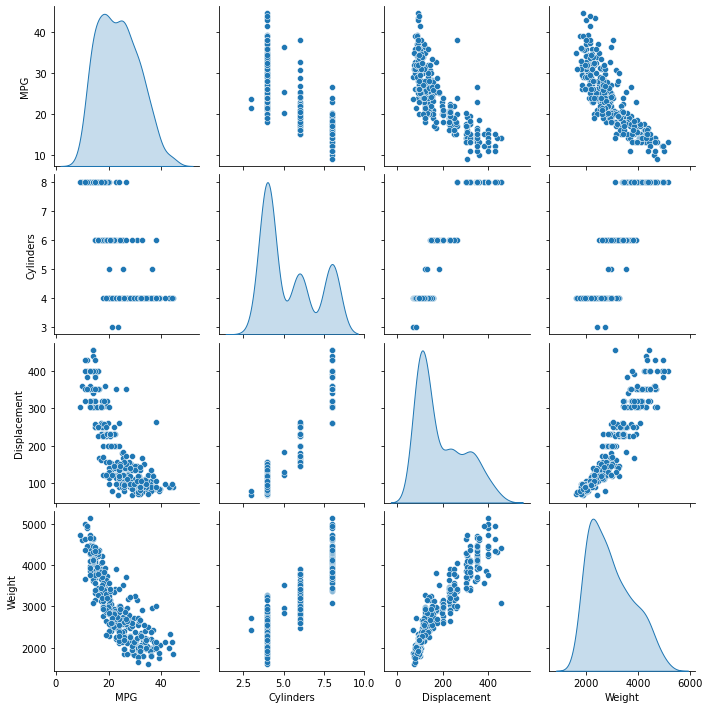

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')